In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def gbm_simulator_with_deltas(S0, mu, sigma, n_days=12, n_sequences=50000, annual_trading_days=252):
    sequences = []
    delta_sequences = []
    
    for i in range(n_sequences):
        # Time horizon and time step
        T = n_days / annual_trading_days
        dt = T / n_days
        
        # Time vector
        t = np.linspace(0, T, n_days)
        
        # Generate Wiener process increments
        W_increments = np.random.normal(0, np.sqrt(dt), n_days)
        W = np.cumsum(W_increments)  # Cumulative Wiener process
        
        # Geometric Brownian Motion (GBM) process
        S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
        
        # Calculate price deltas (differences between consecutive prices)
        Delta_GBM = np.diff(S)  # Price deltas
        
        sequences.append(S)
        delta_sequences.append(Delta_GBM)
    
    return np.array(sequences), np.array(delta_sequences)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, seq_length = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)

    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    # Split the data based on 60/20/20 ratio
    train_size = int(0.6 * n_sequences)
    val_size = int(0.2 * n_sequences)
    
    train_data = tokenized_sequences[:train_size]  # First 60% of sequences for training
    val_data = tokenized_sequences[train_size:train_size + val_size]  # Next 20% for validation
    test_data = tokenized_sequences[train_size + val_size:]  # Remaining 20% for testing

    print('Number of Tokens:', num_bins)
    print('Training Data Shape:', train_data.shape)
    print('Validation Data Shape:', val_data.shape)
    print('Test Data Shape:', test_data.shape)

    return train_data, val_data, test_data, num_bins

def plot_price_hist(price, deltas, bin_width):
    fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

    # Histogram: GBM Prices
    axs[0].hist(np.concatenate(price), bins=20, color='blue', density=True)
    axs[0].set_title('Histogram: GBM Prices')
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Frequency')

    bins = np.arange(-5.1, 5.1 + bin_width, bin_width)

    # Histogram: GBM Price Deltas
    axs[1].hist(np.concatenate(deltas), 
                bins=bins, 
                edgecolor='orange', color='blue', density=True)
    axs[1].set_title('Histogram: GBM Price Deltas')
    axs[1].set_xlabel('Price Difference')
    axs[1].set_ylabel('Frequency')

    # Boxplot Price Deltas
    axs[2].boxplot(np.concatenate(deltas), vert=False)
    axs[2].set_title('Boxplot Price Deltas')
    axs[2].set_xlabel('Price Difference')
    plt.tight_layout()
    plt.show()

def plot_losses(pg_loss, value_loss, entropy_loss):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(pg_loss, color='blue')
    axs[0].set_title('Policy Loss')
    axs[0].set_xlabel('Model Update')
    axs[0].set_ylabel('Value')

    axs[1].plot(value_loss, color='blue')
    axs[1].set_title('Value Loss')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(entropy_loss, color='blue')
    axs[2].set_title('Entropy Loss')
    axs[2].set_xlabel('Model Update')
    axs[2].set_ylabel('Value')
    
    #plt.tight_layout()
    plt.show()

def plot_rewards(ep_rew, ep_len=None, ep_time=None):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(ep_rew, color='blue')
    axs[0].set_title('Episode Reward')
    axs[0].set_ylabel('Reward')
    axs[0].set_xlabel('Episode')

    axs[1].plot(ep_len, color='blue')
    axs[1].set_title('Episode Length')
    axs[1].set_ylabel('Length')
    axs[1].set_xlabel('Episode')

    axs[2].plot(ep_time, color='blue')
    axs[2].set_title('Episode Time in Sec.')
    axs[2].set_ylabel('Time')
    axs[2].set_xlabel('Episode')

    plt.show()

def plot_discriminator():
    pass

Standard Deviation of Price Deltas: 1.263
BIN WIDTH:  0.3
Number of Tokens: 34
Training Data Shape: (30000, 11)
Validation Data Shape: (10000, 11)
Test Data Shape: (10000, 11)


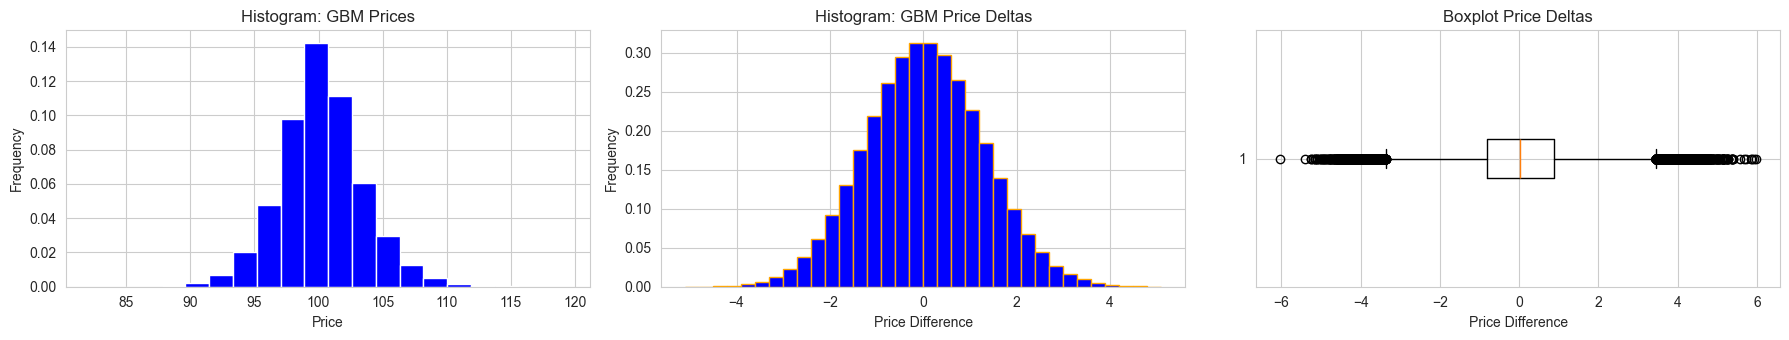

In [3]:
S0 = 100                # Initial stock price
mu = 0.1                # Annual drift
sigma = 0.2             # Volatility
n_days = 12             # Sequence length (52 days)
n_sequences = 50000     # Number of sequences to simulate

Price_GBM, Delta_GBM = gbm_simulator_with_deltas(S0, mu, sigma, n_days=n_days, n_sequences=n_sequences)

bin_width = 0.3
print('Standard Deviation of Price Deltas:', np.round(np.std(Delta_GBM.flatten()),3))
print('BIN WIDTH: ', bin_width)

train_data, val_data, test_data, token_size = tokenize_deltas(Delta_GBM, bin_start=-5.1, bin_stop=5.1, bin_width=bin_width)

plot_price_hist(Price_GBM, Delta_GBM, bin_width)


In [4]:
class Discriminator(nn.Module):
    def __init__(self, sequence_length, hidden_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(sequence_length, hidden_size),            # First layer:              10 -> 256
            nn.ReLU(),                                      
            nn.Linear(hidden_size, hidden_size // 2),           # Second layer:             256 -> 128
            nn.ReLU(),                                      
            nn.Linear(hidden_size // 2, hidden_size // 4),      # Third layer:              128 -> 64
            nn.ReLU(),
            nn.Linear(hidden_size // 4, hidden_size // 8),      # Fourth layer:             64 -> 32
            nn.ReLU(),                                     
            nn.Linear(hidden_size // 8, 1)                      # Output layer (Logits)     32 -> 1
        )
    def forward(self, x):
        # x shape: [batch_size, sequence_length]
        return self.network(x)

In [ ]:
class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug

    Those variables will be accessible in the callback
    (they are defined in the base class)
    The RL model
    self.model = None  # type: BaseRLModel
    An alias for self.model.get_env(), the environment used for training
    self.training_env = None  # type: Union[gym.Env, VecEnv, None]
    Number of time the callback was called
    self.n_calls = 0  # type: int
    self.num_timesteps = 0  # type: int
    local and global variables
    self.locals = None  # type: Dict[str, Any]
    self.globals = None  # type: Dict[str, Any]
    The logger object, used to report things in the terminal
    self.logger = None  # type: logger.Logger
    # Sometimes, for event callback, it is useful
    # to have access to the parent object
    self.parent = None  # type: Optional[BaseCallback]

    train/learning_rate
    train/entropy_loss
    train/policy_gradient_loss
    train/value_loss
    train/approx_kl
    train/clip_fraction
    train/loss
    train/explained_variance
    train/n_updates
    train/clip_range
    """
    
    def __init__(self, verbose=0, display_rollout=False):
        
        super(CustomCallback, self).__init__(verbose)
        
        # Display Rollout
        self.display_rollout = display_rollout
        # Losses
        self.pg_losses, self.value_losses, self.entropy_losses = [], [], []
        # Rewards
        self.rewards = []
        # KL Div
        self.kl_div = []
        # Discriminator
        self.discriminator_loss = []
        self.discriminator_accuracy = []
        
    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        pass

    def _on_rollout_start(self) -> None:

        self.save_losses()

    def _on_step(self) -> bool:

        return True

    def _on_rollout_end(self) -> None:

        if self.display_rollout:
            self.display_rollout_buffer()
        
        self.save_reward()

        ## NEED TO ADJUST FOR MULTIPLE ENVIRONMENTS    
        for env in self.training_env.envs:
            # Calculate KL Div.
            curr_kl =  env.unwrapped.calculate_kl_div()
            # Train Discriminator
            d_loss, d_accuracy = env.unwrapped.train_discrimintator()
            # Reset Lists
            env.unwrapped.clear_rollout_seq()
        
        self.kl_div.append(curr_kl)
        self.discriminator_loss.append(d_loss)
        self.discriminator_accuracy.append(d_accuracy)

        print(f"KL Divergence: {self.kl_div[-1]} - Discriminator Accuracy: {self.discriminator_accuracy[-1]}")

    def _on_training_end(self) -> None:
        
        self.save_losses()

    def save_losses(self) -> None:
        self.pg_losses.append(self.logger.name_to_value.get('train/policy_gradient_loss', None))
        self.value_losses.append(self.logger.name_to_value.get('train/value_loss', None))
        self.entropy_losses.append(self.logger.name_to_value.get('train/entropy_loss', None))

    def display_rollout_buffer(self):
        print("\nRollout Buffer Contents:")
        
        # Get original shaped arrays
        observations = self.model.rollout_buffer.observations  # Shape: (n_steps, n_envs)
        actions = self.model.rollout_buffer.actions
        rewards = self.model.rollout_buffer.rewards
        returns = self.model.rollout_buffer.returns
        episode_starts = self.model.rollout_buffer.episode_starts
        values = self.model.rollout_buffer.values
        log_probs = self.model.rollout_buffer.log_probs
        advantages = self.model.rollout_buffer.advantages
        
        # Print header with line
        header = "  env_id    step    observations  actions  rewards  returns  episode_starts  values  log_probs  advantages"
        print("-" * (len(header) + 5))
        print(header)
        print("-" * (len(header) + 5))
        
        # For each environment
        for env_idx in range(self.training_env.num_envs):
            # Get data for this environment
            env_obs = observations[:, env_idx]
            env_actions = actions[:, env_idx]
            env_rewards = rewards[:, env_idx]
            env_returns = returns[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            env_values = values[:, env_idx]
            env_log_probs = log_probs[:, env_idx]
            env_advantages = advantages[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            
            # Print rows for this environment
            last_idx = -1
            for step in range(len(env_obs)):
                if step in ep_start_idx:
                    if last_idx != -1:
                        print("=" * (len(header) + 5))
                    print(f"Environment {env_idx} - New Episode")
                    print("-" * (len(header) + 5))
                
                # Convert arrays to strings or get first element if array
                obs_str = str(env_obs[step].item()) if hasattr(env_obs[step], 'item') else str(env_obs[step])
                action_str = str(env_actions[step].item()) if hasattr(env_actions[step], 'item') else str(env_actions[step])
                
                print(
                    f"Obs: {obs_str:8s}  "
                    f"Act: {action_str:4s}  "
                    f"Rew: {env_rewards[step]:6.2f}  "
                    f"Ret: {env_returns[step]:7.2f}  "
                    f"Start: {int(env_starts[step]):1d}  "
                    f"Val: {env_values[step]:6.2f}  "
                    f"LogP: {env_log_probs[step]:8.2f}  "
                    f"Adv: {env_advantages[step]:8.2f}")
                
                last_idx = step
            
            print("=" * (len(header) + 5))
            print(f"End of Environment {env_idx}")
            print("\n")

    def save_reward(self):
        # Get rewards without reshaping
        rewards = self.model.rollout_buffer.rewards  # Shape: (n_steps, n_envs)
        episode_starts = self.model.rollout_buffer.episode_starts
        
        all_sequence_rewards = []
        
        # Process each environment separately
        for env_idx in range(self.training_env.num_envs):
            # Get rewards and episode starts for this environment
            env_rewards = rewards[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            if not env_starts[0]:
                ep_start_idx = np.r_[0, ep_start_idx]
                
            # Calculate rewards for this env's sequences
            sequence_rewards = np.add.reduceat(env_rewards, np.r_[0, ep_start_idx[1:]])
            all_sequence_rewards.extend(sequence_rewards)
        
        # Store average across all envs
        self.rewards.append(np.mean(all_sequence_rewards))

    

In [ ]:
class CustomEnv(gym.Env):
    
    def __init__(self, train_data, val_data, token_size, discriminator, d_optimizer):
        
        super(CustomEnv, self).__init__()
        
        # Spaces
        self.action_space = spaces.Discrete(token_size)        # Action Space
        self.observation_space = spaces.Discrete(token_size)   # Observation Spacepass

        # Data
        self.train_data = train_data
        self.val_data = val_data
        
        # Reset
        self.seq_len = None
        self.curr_sim = []
        self.seq_position = 0
    
        # Just to compare KL in training
        self.real_train_seq = []
        self.sim_train_seq = []

        # Discriminator
        self.discriminator = discriminator
        self.d_optimizer = d_optimizer
        self.criterion = nn.BCEWithLogitsLoss()

    def step(self, action):

        assert self.action_space.contains(action), "Invalid Action"

        self.seq_position += 1

        self.curr_sim.append(action)

        done = self._is_done()

        ###=====REWARD=====###
        if done:
            reward = self._get_reward()
            self.sim_train_seq.append(self.curr_sim)
        else:
           reward = 0
        ###=====REWARD=====###

        next_obs = action

        return next_obs, reward, done, False, {}        # observation, reward, done, truncated, info

    def reset(self, *, seed = None, options = None):
        
        seq_idx = np.random.choice(len(self.train_data), size = 1).item()
        real_seq = self.train_data[seq_idx]

        self.real_train_seq.append(real_seq[1:])
        
        # Reset
        self.seq_len = len(real_seq)
        self.curr_sim = []
        self.seq_position = 0
        
        start_token = int(real_seq[0])

        return start_token, {}

    def _is_done(self):

        return self.seq_position == (self.seq_len - 1)

    def _get_reward(self):

        self.discriminator.eval()

        with th.no_grad():
            temp_sequence = th.tensor(np.array(self.curr_seq_sim), dtype=th.float32)
            prediction = self.discriminator(temp_sequence)
            label = th.ones_like(prediction)
            seq_loss = self.criterion(prediction, label)
            reward = -(seq_loss.item())
            return reward

    def clear_rollout_seq(self):
        self.real_train_seq = []
        self.sim_train_seq = []

    def calculate_kl_div(self):

        real_counts = Counter(np.concatenate(self.real_train_seq))
        fake_counts = Counter(np.concatenate(self.sim_train_seq))
        
        total_real = len(np.concatenate(self.real_train_seq))
        total_fake = len(np.concatenate(self.sim_train_seq))
        
        real_probs = {token: count/total_real for token, count in real_counts.items()}
        fake_probs = {token: count/total_fake for token, count in fake_counts.items()}

        eps = 1e-10  # Small constant for numerical stability
        kl = 0
        for token, p_real in real_probs.items():
            p_fake = fake_probs.get(token, eps)
            if p_real > 0:  # Only compute for non-zero probabilities
                kl += p_real * np.log(max(p_real, eps) / max(p_fake, eps))
        
        return kl

    def train_discrimintator(self, epochs):
        
        self.discriminator.train()
        
        discriminator_loss = []
        discriminator_accuracy = []
        
        for epoch in range(epochs):
            
            # Data Prep
            real_data = np.array(self.real_train_seq)
            fake_data = np.array(self.sim_train_seq)
            indices = th.randperm(len(fake_data))
            batch_real = th.tensor(real_data[indices], dtype=th.float32)
            batch_fake = th.tensor(fake_data[indices], dtype=th.float32)

            # Real data
            real_preds = self.discriminator(batch_real)
            real_labels = th.ones_like(real_preds)
            real_loss = self.criterion(real_preds, real_labels)

            # Fake data
            fake_preds = self.discriminator(batch_fake)
            fake_labels = th.zeros_like(fake_preds)
            fake_loss = self.criterion(fake_preds, fake_labels)

            # Loss
            d_loss = (real_loss + fake_loss) / 2

            # Model Update
            self.d_optimizer.zero_grad()
            d_loss.backward()
            self.d_optimizer.step()
            
            # Accuracy
            with th.no_grad():
                 # Convert logits to probabilities using sigmoid
                real_probs = th.sigmoid(real_preds)
                fake_probs = th.sigmoid(fake_preds)
                # Count correct predictions
                correct_real = (real_probs >= 0.52).float().sum()
                correct_fake = (fake_probs < 0.48).float().sum()
                # Total samples
                total_samples = len(real_probs) + len(fake_probs)
                # Overall accuracy
                accuracy = (correct_real + correct_fake) / total_samples
            
            discriminator_loss.append(d_loss.item())
            discriminator_accuracy.append(accuracy.item())
        
        return np.mean(discriminator_loss), np.mean(discriminator_accuracy)



In [7]:
discriminator = Discriminator(sequence_length=10, hidden_size=256)
d_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))

env_test = CustomEnv(train_data=train_data, val_data=val_data, token_size=token_size, discriminator=discriminator, d_optimizer=d_optimizer)
env_test = Monitor(env_test, filename=None) 

model_test = PPO(
    policy='MlpPolicy',
    env=env_test,
    verbose=0,

    n_steps=250*10,
    batch_size=25*10,
    n_epochs=10,

    gamma=0.99,
    gae_lambda=0.95,

    clip_range=0.2,
    clip_range_vf=None,
    ent_coef=0.0,
    vf_coef=0.5,
    max_grad_norm=0.5,

    learning_rate=1e-4
)

callback_test = CustomCallback(verbose=0, display_rollout=False)

In [8]:
model_test.learn(150000, callback=callback_test)
env_test.close()

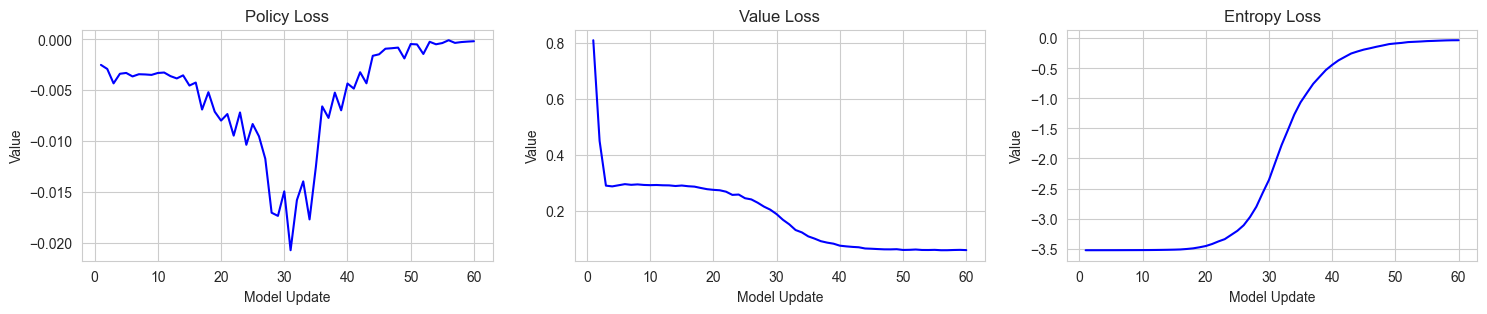

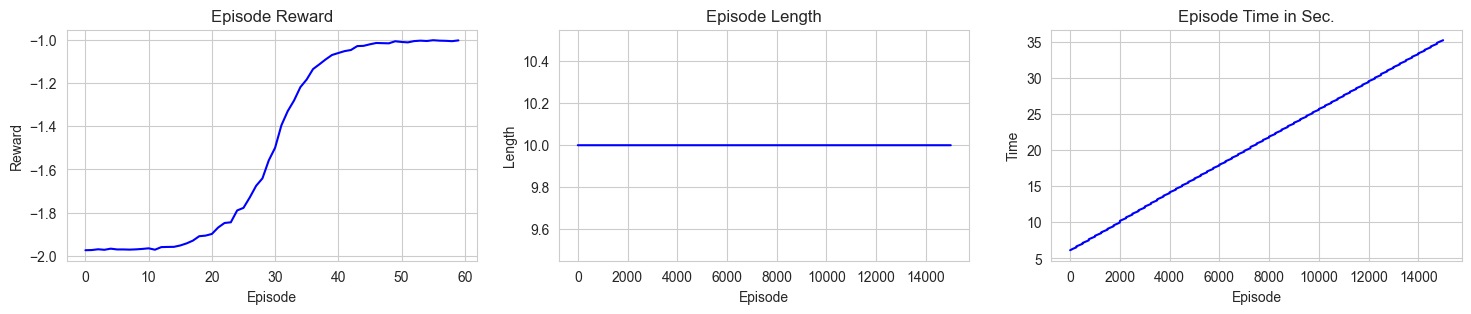

In [9]:
plot_losses(pg_loss=callback_test.pg_losses, 
            value_loss=callback_test.value_losses, 
            entropy_loss=callback_test.entropy_losses)

plot_rewards(ep_rew=callback_test.rewards,
             ep_len=env_test.get_episode_lengths(),
             ep_time=env_test.get_episode_times())

In [190]:
# Create everything
env_taxi = make_vec_env('Taxi-v3', n_envs=5)
callback_taxi = CustomCallback(env=env_taxi, verbose=0, display_rollout=False)

model_taxi = PPO(
    policy="MlpPolicy",
    env=env_taxi,
    verbose=0,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    learning_rate=3e-4,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    clip_range_vf=None,
    ent_coef=0.0,
    vf_coef=0.5,
    max_grad_norm=0.5
)

In [191]:
# Train with callback
model_taxi.learn(total_timesteps=200000, callback=callback_taxi)

# Don't forget to close!
env_taxi.close()

In [8]:
plot_losses(pg_loss=callback_taxi.pg_losses, 
            value_loss=callback_taxi.value_losses, 
            entropy_loss=callback_taxi.entropy_losses)

plot_rewards(ep_rew=callback_taxi.rewards,
             #ep_len=env_taxi.get_episode_lengths(),
             #ep_time=env_taxi.get_episode_times())
             )

NameError: name 'callback_taxi' is not defined

In [ ]:
def display_rollout_buffer2(self):
    print("\nRollout Buffer Contents:")
    
    # Create base DataFrame with flattened arrays
    df = pd.DataFrame({
        'observations': self.model.rollout_buffer.observations.reshape(-1),
        'actions': self.model.rollout_buffer.actions.reshape(-1),
        'rewards': self.model.rollout_buffer.rewards.reshape(-1),
        'returns': self.model.rollout_buffer.returns.reshape(-1),
        'episode_starts': self.model.rollout_buffer.episode_starts.reshape(-1),
        'values': self.model.rollout_buffer.values.reshape(-1),
        'log_probs': self.model.rollout_buffer.log_probs.reshape(-1),
        'advantages': self.model.rollout_buffer.advantages.reshape(-1)
    })
    
    # Find indices where episodes start
    episode_starts = np.where(df['episode_starts'])[0]
    
    # Create list to store all rows
    all_rows = []
    
    # Print header with line
    header = "  observations  actions  rewards  returns  episode_starts  values  log_probs  advantages"
    print("-" * (len(header) + 5))  # +5 for index space
    print("idx " + header)
    print("-" * (len(header) + 5))
    
    last_idx = -1
    for i in range(len(df)):
        if i in episode_starts:
            # Add double line if this is end of previous episode (not first episode)
            if last_idx != -1:
                print("=" * (len(header) + 5))
            # Add "New Episode" row
            print(f"{i:3d} {'New Episode':^{len(header)}}")
            print("-" * (len(header) + 5))
            
        # Format row data with 2 decimal places
        row = df.iloc[i]
        print(f"{i:3d}  {row['observations']:8.0f}    {row['actions']:4.0f}    {row['rewards']:6.2f}  "
            f"{row['returns']:7.2f}  {row['episode_starts']:8.0f}      "
            f"{row['values']:6.2f}  {row['log_probs']:8.2f}  {row['advantages']:9.2f}")
        
        last_idx = i
    
    # Add final double line
    print("=" * (len(header) + 5))
    print('\n')